In [73]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

In [74]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [75]:
#from training_data take out only 3 classes (0,1,2)
training_data = Subset(training_data, [i for i in range(len(training_data)) if training_data[i][1] in [0,1,2]])
test_data = Subset(test_data, [i for i in range(len(test_data)) if test_data[i][1] in [0,1,2]])

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)



In [76]:

print(len(training_data))
print(len(test_data))

15000
3000


In [77]:
# do stratified split of training_data into train and validation in ratio 80:20
from sklearn.model_selection import train_test_split
import numpy as np


train_indices, val_indices = train_test_split(np.arange(len(training_data)), test_size=0.2, stratify=[training_data[i][1] for i in range(len(training_data))])

train_data = Subset(training_data, train_indices)
val_data = Subset(training_data, val_indices)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

print(len(train_data))
print(len(val_data))


12000
3000


In [78]:
classes = ('plane', 'car', 'bird')

Class: plane


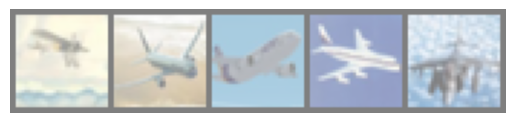

Class: car


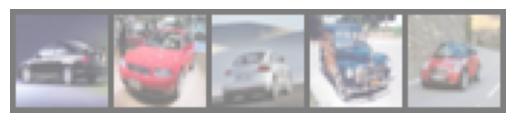

Class: bird


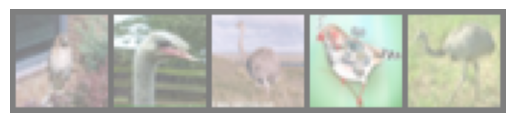

In [79]:
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np


def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Turn off axis labels
    plt.show()

class_images = {cls: [] for cls in classes}  


for images, labels in train_dataloader:
    for i, label in enumerate(labels):
        class_label = classes[label.item()]
        if len(class_images[class_label]) < 5:
            class_images[class_label].append(images[i])
        # Stop if we have collected 5 images for all classes
        if all(len(images_list) >= 5 for images_list in class_images.values()):
            break
    if all(len(images_list) >= 5 for images_list in class_images.values()):
        break

for class_label, images in class_images.items():
    print(f'Class: {class_label}')
    imshow(torchvision.utils.make_grid(images))


In [80]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(kernel_size=5, in_channels=3, out_channels=16, padding=1, stride=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(kernel_size=3, in_channels=16, out_channels=32, padding=0, stride=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=3)

        self.fc1 = nn.Linear(32*6*6, 16)
        self.fc2 = nn.Linear(16, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
)


In [81]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x512 and 1152x16)